In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Masking, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import model_from_json
from keras.callbacks import History, CSVLogger
from keras.utils import plot_model
import keras.backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import numpy
import json
import pandas as pd
import pickle
import numpy as np
from numpy import *
from os import listdir
from os.path import isfile, join
from sklearn.linear_model import LogisticRegression

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
root = 'data/root/'
train_path = 'data/root/train'
test_path = 'data/root/test'
#below can path can be set to any folder if extracting Phenotype score rather than using pre-extracted.
phenotype_features = '/Users/rajeshpothamsetty/Dropbox/Rajesh_DB/IMP_Dropbox/OMSCS/BigData/'
#below are results folders from Scala/Spark
feature_without_chart_path = '/Users/rajeshpothamsetty/Downloads/Results_update/features_exclude_chart/'
feature_with_only_chart_path = '/Users/rajeshpothamsetty/Downloads/Results_update/features_only_chart/'

In [7]:
all_stays = pd.read_csv(root + "all_stays.csv")

In [8]:
# creating binary features from LAST_CAREUNIT and a cumulative count of number of icu stays of a patient till 
# that point as one other feature.
care_units = all_stays[['ICUSTAY_ID', 'LAST_CAREUNIT']]
stay_ids = care_units['ICUSTAY_ID']
care_units = care_units['LAST_CAREUNIT'].str.get_dummies(',')
care_units['ICUSTAY_ID'] = stay_ids

cum_stay = all_stays[['SUBJECT_ID', 'ICUSTAY_ID']]
cum_stay['cum'] =1
cum_stay['ICU_CUM'] = cum_stay.groupby('SUBJECT_ID')['cum'].cumsum()
cum_stay = cum_stay[['ICUSTAY_ID', 'ICU_CUM']]

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
feature_set = pd.merge(cum_stay, care_units, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')

#### phenotype extraction cell

In [11]:
#Extracting Phenotype Score from the train and test folders of benchmark data
#No need to run this, as it has been already run and saved
train_pt = [f for f in listdir(train_path)]
test_pt = [f for f in listdir(test_path)]

train_pt = train_pt[1:len(train_pt)]
test_pt = train_pt[1:len(test_pt)]

def get_phenScore(p_id):
    diagnoses_path = train_path + '/' + p_id + '/' + 'diagnoses.csv'
    diagnoses = pd.read_csv(diagnoses_path, sep = ",", header = 'infer')
    diagnoses = diagnoses.groupby('ICUSTAY_ID').agg({'USE_IN_BENCHMARK' : 'sum'}).reset_index().rename(columns = {'USE_IN_BENCHMARK' : 'Phentotype_Score'})
    return diagnoses

score_df_train = map(get_phenScore, train_pt)
score_df_test = map(get_phenScore, test_pt)

phenotype_train = pd.concat(score_df_train)
phenotype_test = pd.concat(score_df_test)
phenotype_test.head(10)

phenotype_train.to_csv(phenotype_features + 'phenotype_train.csv')
phenotype_test.to_csv(phenotype_features + 'phenotype_test.csv')

,ICUSTAY_ID,Phentotype_Score
0,258326,5
0,216403,2
0,268419,3
1,279204,4
0,206504,8
0,286008,7
0,280464,0
0,264446,6
0,240226,0
0,204881,7


In [11]:
phenotype_train = pd.read_csv( all_features +'phenotype_train.csv', delimiter=",", header= 0)[['ICUSTAY_ID', 'Phentotype_Score']]
phenotype_test = pd.read_csv( all_features +'phenotype_train.csv', delimiter=",", header= 0)[['ICUSTAY_ID', 'Phentotype_Score']]
phenotype_test.head(5)

,ICUSTAY_ID,Phentotype_Score
0,221100,2.0
1,258326,5.0
2,216403,2.0
3,268419,3.0
4,279204,4.0


#### load pre-extracted phenotype scores

In [12]:
# adding PhenotypeScore to the feature set
feature_set1_train = pd.merge(feature_set, phenotype_train, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
feature_set1_test = pd.merge(feature_set, phenotype_test, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')

In [13]:
#Feature Extracted directly from MIMIC3 data (these are highly populated features excluding chart events)
#dataset = np.loadtxt( feature_set2_path + "features_value_without_masks.txt", delimiter=",",dtype = 'str')
dataset_df = pd.read_csv(feature_without_chart_path + "features_value_without_masks.txt", delimiter=",", header= None)
#dataset_df = pd.DataFrame(dataset)
dataset_df[0].replace('', np.nan, inplace=True)
dataset_df.dropna(subset=[0], inplace=True)
dataset_df = dataset_df.rename(columns = {0 : 'ICUSTAY_ID'}) 
dataset_df = dataset_df.rename(columns = {50 : 'mortality'}) 
print(dataset_df.iloc[:, 46:52].head())

         46   47   48   49  mortality   51
0  0.046739  3.0  0.0  0.0        NaN  0.0
1  0.116839  1.0  0.0  0.0        0.0  0.0
2  0.071716  0.0  0.0  0.0        0.0  0.0
3  0.769396  1.0  0.0  1.0        1.0  5.0
4  0.196366  0.0  0.0  0.0        0.0  0.0


In [14]:
#adding previous extracted cumulative icu count, Pheno score and last_care unit to the features extracted above
phenotype_train['ICUSTAY_ID'] = phenotype_train['ICUSTAY_ID'].astype(int)
dataset_df['ICUSTAY_ID'] = dataset_df['ICUSTAY_ID'].astype(int)
dataset_train_merge = pd.merge(dataset_df, phenotype_train, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
dataset_test_merge = pd.merge(dataset_df, phenotype_test, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')                                                       

feature_set2_train = pd.merge(feature_set1_train, dataset_train_merge, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
feature_set2_test = pd.merge(feature_set1_test, dataset_test_merge, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')  

#cleaning/removing dup feature
feature_set2_train = feature_set2_train.drop('Phentotype_Score_x', 1)
feature_set2_train = feature_set2_train.rename(columns = {'Phentotype_Score_y' : 'Phentotype_Score'}) 
feature_set2_test = feature_set2_test.drop('Phentotype_Score_x', 1)
feature_set2_test = feature_set2_test.rename(columns = {'Phentotype_Score_y' : 'Phentotype_Score'}) 

#### Model for Chart Events Alone

In [15]:
dataset_df = pd.read_csv(feature_with_only_chart_path + "feature_value_with_masks.txt", delimiter=",", header= None)

# removing any blank icustayIds
dataset_df[0].replace('', np.nan, inplace=True)
dataset_df.dropna(subset=[0], inplace=True)
dataset_df[0] = pd.to_numeric(dataset_df[0])
dataset_df[0] = dataset_df[0].astype(int)
dataset_df = dataset_df.rename(columns = {0 : 'ICUSTAY_ID'}) 

# merging to separate train/test
dataset_train_merge = pd.merge(dataset_df, phenotype_train, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
dataset_test_merge = pd.merge(dataset_df, phenotype_test, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')

dataset_train = dataset_train_merge.values
dataset_test = dataset_test_merge.values

In [16]:
#prepare X_train and Y_train, 2330 column number of mortality
X1 = np.delete(dataset_train, 2330, axis=1)
X1 = np.delete(X1, 0, axis=1)
#replace blank value with any number which doesnt show up as acceptable value in chart events
#we have binary feature for each of these missing values, with 1 representing a missing value
X1[X1 == np.nan] = '-10'
X1[isnan(X1)] = '-10'
X1 = X1.astype(float)

Y1 = dataset_train[:,2330]
Y1[Y1 == ''] = '0.0'
Y1 = Y1.astype(float)

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [17]:
Y1_test = dataset_test[:,2330]
Y1_test[Y1_test == ''] = '0.0'
Y1_test = Y1_test.astype(float)

X1_test = np.delete(dataset_test, 2330, axis=1)
X1_test = np.delete(X1_test, 0, axis=1)
X1_test[X1_test == ''] = '-10'
X1_test = X1_test.astype(float)
X1_test[isnan(X1_test)] = '-10'
X1_test = X1_test.astype(float)

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


#### model for Chart Events Only or (Chart + Normal Features)

In [19]:
def create_model_with_dropout(loss, optimizer, init, input_dim, learning_rate = 0, decay = 0, momentum = 0.8, dropout = 0.2):

    def weighted_binary_crossentropy(y_true, y_pred):
        one_weight = 0.91
        zero_weight = 0.09
        b_ce = binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)

    # create model
    model = Sequential()
    #model.add(Masking(mask_value = -12358.0)(inputs))
    model.add(Dropout(dropout, input_shape=(input_dim,)))
    model.add(Dense(6000, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(3000, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(1500, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(700, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(300, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(100, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   
    # setting SGD params
    if (optimizer == 'sgd'):
        optim_algo = optimizers.SGD(lr= learning_rate, decay = decay, momentum = momentum, nesterov = True)
    elif (optimizer == 'adam'):
        # Keras default: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0.
        optim_algo = optimizers.adam(lr = learning_rate, beta_1 = decay, beta_2 = momentum, epsilon = 10E-8)
    else:
        optim_algo = optimizer
        
    # Compile model
    model.compile(loss = weighted_binary_crossentropy, optimizer= optim_algo, metrics=['accuracy', 'mae', 'categorical_accuracy'])
    return model 

In [20]:
# setting up the Grid Params
# In our test runs, 'adam' optimizer was found to be the best optimizer with it's standard settings without much tuning
optimizer_list = ['adam', 'sgd'] #Adadelta, Adagrad
init_list = ['glorot_uniform', 'normal', 'uniform']
loss_list = ['weighted_binary_crossentropy']
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2]
learning_rate_decays = [0.001, 0.005, 0.01]
momentum = [0.7, 0.8, 0.9]
dropout = [0.2, 0.25, 0.3]

In [21]:
#### Including standardization in the GridSearch and CrossValidation process
model = KerasClassifier(build_fn = create_model_with_dropout, verbose = 1) # , batch_size = 1000

input_dim = 12927 #input features
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn', model))
pipeline = Pipeline(estimators)

# Standard 'Adam' optimaztion parameters are given here. 
#found to be performing better than 'sgd' without much tuning due to it's adaptible nature

param_grid_pipe = { 'nn' : [model],
                    'nn__optimizer': ['adam'],
                  'nn__epochs' : [10],
                  'nn__batch_size' : [1000],
                  'nn__init' : ['glorot_uniform'],
                  'nn__loss' : loss_list,
                 'nn__learning_rate' : [0.001],
                  'nn__decay' : [0.9],
                  'nn__momentum' : [0.999],
                   'nn__input_dim' : [input_dim]
                  }

#pipeline.get_params().keys()
grid1_ = GridSearchCV(estimator=pipeline, param_grid=param_grid_pipe, n_jobs = 1, cv = 5, refit= True)
grid_result_pipe_ = grid1_.fit(X1, Y1)

Epoch 1/10
28753/28753 [==============================] - 239s 8ms/step - loss: 0.0859 - acc: 0.8602 - mean_absolute_error: 0.1816 - categorical_accuracy: 1.0000
Epoch 2/10
28753/28753 [==============================] - 205s 7ms/step - loss: 0.0396 - acc: 0.9158 - mean_absolute_error: 0.1296 - categorical_accuracy: 1.0000
Epoch 3/10
28753/28753 [==============================] - 148s 5ms/step - loss: 0.0310 - acc: 0.9393 - mean_absolute_error: 0.0978 - categorical_accuracy: 1.0000
Epoch 4/10
28753/28753 [==============================] - 151s 5ms/step - loss: 0.0263 - acc: 0.9463 - mean_absolute_error: 0.0818 - categorical_accuracy: 1.0000
Epoch 5/10
28753/28753 [==============================] - 146s 5ms/step - loss: 0.0227 - acc: 0.9555 - mean_absolute_error: 0.0703 - categorical_accuracy: 1.0000
Epoch 6/10
28753/28753 [==============================] - 144s 5ms/step - loss: 0.0220 - acc: 0.9584 - mean_absolute_error: 0.0671 - categorical_accuracy: 1.0000
Epoch 7/10
28753/28753 [====

28754/28754 [==============================] - 152s 5ms/step - loss: 0.0181 - acc: 0.9660 - mean_absolute_error: 0.0554 - categorical_accuracy: 1.0000
Epoch 9/10
28754/28754 [==============================] - 151s 5ms/step - loss: 0.0177 - acc: 0.9660 - mean_absolute_error: 0.0542 - categorical_accuracy: 1.0000
Epoch 10/10
28754/28754 [==============================] - 44s 2ms/step
Epoch 1/10
35942/35942 [==============================] - 206s 6ms/step - loss: 0.1024 - acc: 0.8508 - mean_absolute_error: 0.1923 - categorical_accuracy: 1.0000
Epoch 2/10
35942/35942 [==============================] - 202s 6ms/step - loss: 0.0397 - acc: 0.9137 - mean_absolute_error: 0.1316 - categorical_accuracy: 1.0000
Epoch 3/10
35942/35942 [==============================] - 200s 6ms/step - loss: 0.0304 - acc: 0.9392 - mean_absolute_error: 0.0958 - categorical_accuracy: 1.0000
Epoch 4/10
35942/35942 [==============================] - 206s 6ms/step - loss: 0.0265 - acc: 0.9474 - mean_absolute_error: 0.082

In [23]:
Y_train1_prob = grid_result_pipe_.predict_proba(X1)
X_Y_train = np.vstack((dataset_train[:,0], Y_train1_prob[:,1])).T
XY_train_df = pd.DataFrame(X_Y_train)
XY_train_df.columns = ['ICUSTAY_ID', 'ChartDNN_pred']

35942/35942 [==============================] - 62s 2ms/step


#### Model for Non_Chart features (highly populated)

In [30]:
dataset_train2 = feature_set2_train.values
dataset_test2 = feature_set2_test.values

Y1_train2 = dataset_train2[:,56]
X1_train2 = np.delete(dataset_train2, 56, axis=1)
print(X1_train2.shape)
X1_train2 = np.delete(X1_train2, 0, axis=1)
#print(pd.DataFrame(X1_train).head())
#print(pd.DataFrame(X1_train).iloc[:, 55:58].head())
X1_train2[X1_train2 == np.nan] = 0.0
X1_train2 = X1_train2.astype(float)
Y1_train2[Y1_train2 == ''] = 0.0
Y1_train2 = Y1_train2.astype(float)

(35942, 67)


In [31]:
Y1_test2 = dataset_test2[:,56]
X1_test2 = np.delete(dataset_test2, 56, axis=1)
print(X1_test2.shape)
X1_test2 = np.delete(X1_test2, 0, axis=1)
#print(pd.DataFrame(X1_train).head())
#print(pd.DataFrame(X1_train).iloc[:, 55:58].head())
X1_test2[X1_test2 == np.nan] = 0.0
X1_test2 = X1_test2.astype(float)
Y1_test2[Y1_test2 == ''] = 0.0
Y1_test2 = Y1_test2.astype(float)

X1_train2[isnan(X1_train2)] = 0.0
X1_train2 = X1_train2.astype(float)

X1_test2[isnan(X1_test2)] = 0.0
X1_test2 = X1_test2.astype(float)

(6605, 67)


/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [38]:
def create_model_with_dropout_normF(loss, optimizer, init, learning_rate = 0, decay = 0, momentum = 0.8, dropout = 0.2):

    def weighted_binary_crossentropy(y_true, y_pred):
        one_weight = 0.91
        zero_weight = 0.09
        b_ce = binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)

    # create model
    model = Sequential()
    model.add(Dropout(dropout, input_shape=(66,)))
    model.add(Dropout(dropout))
    model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   
    # setting SGD params
    if (optimizer == 'sgd'):
        optim_algo = optimizers.SGD(lr= learning_rate, decay = decay, momentum = momentum, nesterov = True)
    elif (optimizer == 'adam'):
        # Keras default: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0.
        optim_algo = optimizers.adam(lr = learning_rate, beta_1 = decay, beta_2 = momentum, epsilon = 10E-8)
    else:
        optim_algo = optimizer       
    # Compile model
    model.compile(loss = weighted_binary_crossentropy, optimizer= optim_algo, metrics=['accuracy', 'mae', 'categorical_accuracy'])
    return model 

In [65]:
#### Including standardization in the GridSearch and CrossValidation process
model_normF = KerasClassifier(build_fn = create_model_with_dropout_normF, verbose = 1) # , batch_size = 1000

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn', model_normF))
pipeline = Pipeline(estimators)

param_grid_pipe = { 'nn' : [model_normF],
                    'nn__optimizer': ['adam'],
                  'nn__epochs' : [5],
                  'nn__batch_size' : [1000],
                  'nn__init' : ['glorot_uniform'],
                  'nn__loss' : loss_list,
                 'nn__learning_rate' : [0.001],
                  'nn__decay' : [0.9],
                  'nn__momentum' : [0.999]
                  }

#pipeline.get_params().keys()
grid2 = GridSearchCV(estimator=pipeline, param_grid=param_grid_pipe, n_jobs = 1, cv = 5, refit= True)
grid_result_normF = grid2.fit(X1_train2, Y1_train2)

Epoch 1/5
28753/28753 [==============================] - 2s 56us/step - loss: 0.1078 - acc: 0.9065 - mean_absolute_error: 0.4915 - categorical_accuracy: 1.0000
Epoch 2/5
28753/28753 [==============================] - 0s 17us/step - loss: 0.0979 - acc: 0.9154 - mean_absolute_error: 0.4577 - categorical_accuracy: 1.0000
Epoch 3/5
28753/28753 [==============================] - 0s 16us/step - loss: 0.0757 - acc: 0.9154 - mean_absolute_error: 0.3689 - categorical_accuracy: 1.0000
Epoch 4/5
28753/28753 [==============================] - 0s 17us/step - loss: 0.0517 - acc: 0.9154 - mean_absolute_error: 0.2485 - categorical_accuracy: 1.0000
Epoch 5/5
28753/28753 [==============================] - 0s 5us/step
Epoch 1/5
28753/28753 [==============================] - 2s 55us/step - loss: 0.1081 - acc: 0.8939 - mean_absolute_error: 0.4944 - categorical_accuracy: 1.0000
Epoch 2/5
28753/28753 [==============================] - 0s 17us/step - loss: 0.1006 - acc: 0.9166 - mean_absolute_error: 0.4694 - 

In [41]:
Y_train_prob2 = grid_result_normF.predict_proba(X1_train2)
X_Y_train2 = np.vstack((dataset_train2[:,0], Y_train_prob2[:,1])).T
XY_train_df2 = pd.DataFrame(X_Y_train2)
XY_train_df2.columns = ['ICUSTAY_ID', 'normF_pred']

35942/35942 [==============================] - 0s 10us/step


##### Normal Feature NN Performance

In [45]:
# normF train accuracy scores
y_train_pred = grid2.predict(X1_train2)
from sklearn.metrics import *
accuracy_score(Y1_train2, y_train_pred)

35942/35942 [==============================] - 0s 1us/step


0.9146680763452228

In [57]:
#normF test accuracy
y_test_pred = grid2.predict(X1_test2)
ACC = accuracy_score(Y1_test2, y_test_pred)

6605/6605 [==============================] - 0s 1us/step


35942/35942 [==============================] - 0s 1us/step


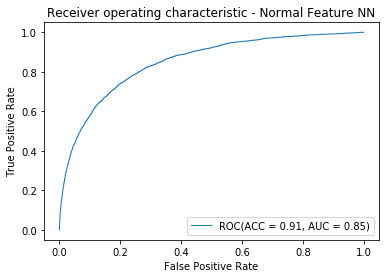

In [64]:
y_train_prob2 = grid2.predict_proba(X1_train2)
#plotting normF train roc_curve
fpr, tpr, thresholds = roc_curve(Y1_train2, y_train_prob2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=3, label='ROC(ACC = %0.2f, AUC = %0.2f)' % (ACC, roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Normal Feature NN')
plt.legend(loc="lower right")
plt.show()

6605/6605 [==============================] - 0s 1us/step


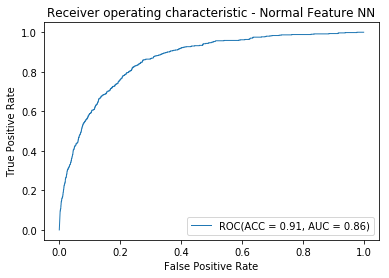

In [62]:
y_test_prob2 = grid2.predict_proba(X1_test2)
#plotting normF test roc_curve
fpr, tpr, thresholds = roc_curve(Y1_test2, y_test_prob2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=3, label='ROC(ACC = %0.2f, AUC = %0.2f)' % (ACC, roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Normal Feature NN')
plt.legend(loc="lower right")
plt.show()

##### Chart Events DNN Performance

In [68]:
#Train Accuracy
y_train1_pred = grid1.predict(X1)
from sklearn.metrics import *
accuracy_score(Y1, y_train1_pred)

35942/35942 [==============================] - 67s 2ms/step


0.9694229592120639

In [67]:
#Test Accuracy
y_test1_pred = grid1.predict(X1_test)
accuracy_score(Y1_test, y_test1_pred)

6605/6605 [==============================] - 12s 2ms/step


0.9706283118849357

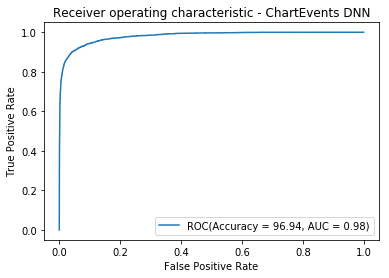

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

#plotting train roc_curve
fpr, tpr, thresholds = roc_curve(Y1, Y_train1_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, alpha=4, label='ROC(Accuracy = %0.2f, AUC = %0.2f)' % (96.94, roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - ChartEvents DNN')
plt.legend(loc="lower right")
plt.show()

6605/6605 [==============================] - 10s 1ms/step


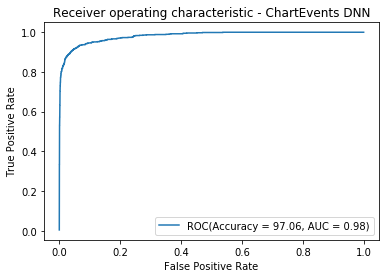

In [84]:
#plotting roc_curve
Y_test_prob = grid1.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Y_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, alpha=4, label='ROC(Accuracy = %0.2f, AUC = %0.2f)' % (97.06, roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - ChartEvents DNN')
plt.legend(loc="lower right")
plt.show()

#### BenchMark LSTM Model Performance

In [80]:
lstm_predictions = pd.read_csv(root + 'predictions.csv')
columns = ['ICUSTAY_ID', 'Ybm_prob', 'Ybm_true']
lstm_predictions.columns = columns

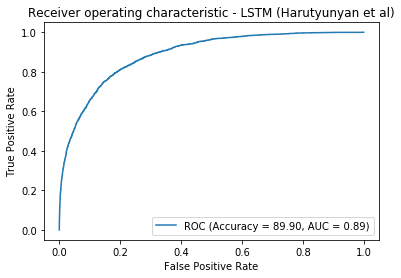

In [86]:
Y1_bm_prob = np.array(lstm_predictions['Ybm_prob'])
Y1_bm_true = np.array(lstm_predictions['Ybm_true'])

#plotting roc_curve
fpr, tpr, thresholds = roc_curve(Y1_bm_true, Y1_bm_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, alpha=6, label='ROC (Accuracy = %0.2f, AUC = %0.2f)' % (89.9 ,roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - LSTM (Harutyunyan et al)')
plt.legend(loc="lower right")
plt.show()

#### Ensemble of 3 Predictions

In [89]:
chart_norfF_pred = pd.merge(XY_train_df, XY_train_df2, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
chart_norfF_pred.head()

,ICUSTAY_ID,ChartDNN_pred,normF_pred
0,298170,0.000056,0.0108658
1,262940,0.000366,0.00536802
2,205310,0.001068,0.00406721
3,279090,0.000096,0.0270403
4,237650,0.215034,0.0204256


In [95]:
all_3_predictions = pd.merge(chart_norfF_pred, lstm_predictions, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
all_3_predictions.head()

,ICUSTAY_ID,ChartDNN_pred,normF_pred,Ybm_prob,Ybm_true
0,279090,0.000096,0.0270403,0.037024,0
1,267000,0.000172,0.223132,0.318073,1
2,261770,0.000006,0.0354497,0.614406,0
3,296790,0.000051,0.0541182,0.058790,0
4,217010,0.974400,0.270199,0.003936,0


In [96]:
data_all = all_3_predictions.values

X1_all = np.delete(data_all, 4, axis=1)
X1_all = np.delete(X1_all, 0, axis=1)
Y1_all = data_all[:,4]
X1_all[X1_all == np.nan] = 0.0
X1_all = X1_all.astype(float)
Y1_all[Y1_all == ''] = 0.0
Y1_all = Y1_all.astype(float)
X1_all[isnan(X1_all)] = 0.0
X1_all = X1_all.astype(float)

(17903, 4)


In [130]:
# class_weight = {0:.8, 1:.2}
# 
LR_fit = LogisticRegression(penalty= 'l1', fit_intercept = True).fit(X1_all, Y1_all, sample_weight=None)

In [131]:
Y1_all_prob = LR_fit.predict_proba(X1_all)
Y1_all_prob

array([[0.96255121, 0.03744879],
       [0.75227908, 0.24772092],
       [0.24210907, 0.75789093],
       ...,
       [0.96584891, 0.03415109],
       [0.93960313, 0.06039687],
       [0.96984167, 0.03015833]])

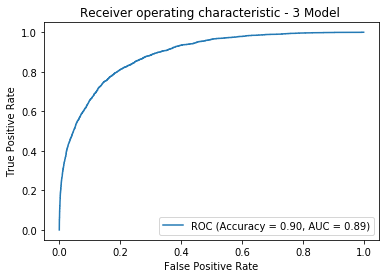

In [132]:
Y1_all_pred = LR_fit.predict(X1_all)
acc_3model = accuracy_score(Y1_all, Y1_all_pred)
#plotting roc_curve
fpr, tpr, thresholds = roc_curve(Y1_all, Y1_all_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, alpha=6, label='ROC (Accuracy = %0.2f, AUC = %0.2f)' % (acc_3model ,roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - 3 Model ')
plt.legend(loc="lower right")
plt.show()